In [2]:
# general
import sys, os, path
import datetime

# nn related
import torch as th
import numpy as np
from numpy import linalg as la
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# postprocessing
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
import seaborn as sns

# own scrips
sys.path.insert(1, '/home/leonriccius/PycharmProjects/data_driven_rans')

from scripts import preProcess as pre
from scripts import TensorBasedNN
from scripts.TensorBasedNN import TBNN_generic
from scripts.utilities import * # get_invariants, get_tensor_functions, sigmoid_scaling, mean_std_scaling
from scripts.torchToFoam import writesymmtensor
from scripts.barymap import BarMap
from scripts import *

# standard datatype
dtype = th.double

In [3]:
# path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/Re13700_kOmega_150_ml'
# rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
# print(rans_time)

# grid_rans = pre.readCellCenters(rans_time, path)
# u_rans = pre.readVectorData(rans_time, 'U', path)
# u_levm = pre.readVectorData('3000', 'U', path)

# path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata/CurvedBackwardFacingStep/13700'
# grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
# u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))

In [60]:
# read in rans solution from b_ml
path = '/home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/Re13700_kOmega_150_ref_x_ml_low_lr'
rans_time = max([int(entry) for entry in os.listdir(path) if entry.isnumeric()])
grid_rans = pre.readCellCenters(rans_time, path)
u_rans = pre.readVectorData(rans_time, 'U', path)
u_levm = pre.readVectorData('7000', 'U', path)

# # read in rans solution from b_dns
# path_rans_bdns = '/home/leonriccius/Desktop/PeriodicHills/Re5600/Re5600_kOmega_150_dns/'
# rans_time = max([int(entry) for entry in os.listdir(path_rans_bdns) if entry.isnumeric()])
# u_rans_dns = pre.readVectorData(rans_time, 'U', path_rans_bdns)

# read in dns solution
path_dns = '/home/leonriccius/Documents/Fluid_Data/tensordata_fs1_fs2_fs3_reduced/CurvedBackwardFacingStep/13700'
grid_dns = th.load(os.sep.join([path_dns, 'grid-torch.th']))
u_dns = th.load(os.sep.join([path_dns, 'u_dns-torch.th']))

Reading mesh cell centers /home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/Re13700_kOmega_150_ref_x_ml_low_lr/9000/cellCenters
Attempting to read file: /home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/Re13700_kOmega_150_ref_x_ml_low_lr/9000/U
Parsing file...
Data field file successfully read.
Attempting to read file: /home/leonriccius/Desktop/CurvedBackwardFacingStep/ratio_20/Re13700_kOmega_150_ref_x_ml_low_lr/7000/U
Parsing file...
Data field file successfully read.


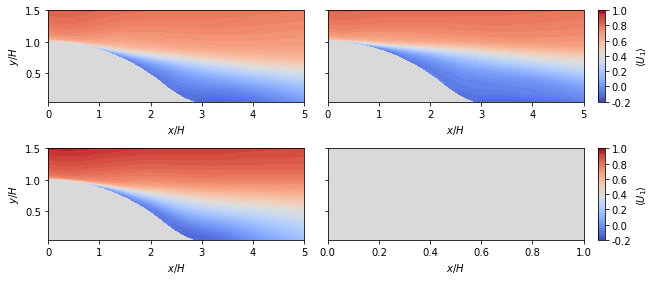

In [73]:
# set refinement level and extent of grid
ref = 15
gamma = 0.995

# # find min an max of x coordinate
# x_min, x_max = np.min(grid_rans[:,0].numpy()), np.max(grid_rans[:,0].numpy())
# x_mean = 0.5*(x_max - x_min)
# x_min = x_mean - gamma*(x_mean - x_min)
# x_max = x_mean - gamma*(x_mean - x_max)

# # find min an max of y coordinate
# y_min, y_max = np.min(grid_rans[:,1].numpy()), np.max(grid_rans[:,1].numpy())
# y_mean = 0.5*(y_max - y_min)
# y_min = y_mean - gamma*(y_mean - y_min)
# y_max = y_mean - gamma*(y_mean - y_max)

# define extent of plots
x_min = [-0.0, 0.05]
x_max = [5.0, 1.5]

# compute number of points per coordinate
np_x = int(ref*(x_max[0] - x_min[0]))
np_y = int(ref*(x_max[1] - x_min[1]))

# get grid and shift points on curved boundaries
grid_x, grid_y = np.meshgrid(np.linspace(x_min[0], x_max[0], np_x), np.linspace(x_min[1], x_max[1], np_y))
grid_y_shifted = cbfs_interp(grid_x)*(x_max[1] - grid_y)/x_max[1] + grid_y
grid_y = grid_y_shifted

# interpolate u
grid_u_rans = griddata(grid_rans[:,0:2], u_rans.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_levm = griddata(grid_rans[:,0:2], u_levm.detach().numpy(), (grid_x, grid_y), method = 'linear')
grid_u_dns = griddata(grid_dns[:,0:2], u_dns.detach().numpy(), (grid_x, grid_y), method = 'linear') #, fill_value=0.)

# get min an max of (b_pred, b_test) for colormap
idx = [0]
tmp = np.vstack((grid_u_rans[:,:,0], grid_u_levm[:,:,0], grid_u_dns[:,:,0]))
u_min = np.min(tmp)
u_max = np.max(tmp)
# levels = np.linspace(u_min, u_max, 50)
levels = np.linspace(-0.2, 1.0, 50)

# plot layout
nrows = 2
ncols = 2
s = 1.0

# create figure
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(s*4.5*ncols, s*1.9*nrows), sharex=False, sharey=True,
                       constrained_layout=True)

cmap = matplotlib.cm.get_cmap("coolwarm")
# cmap.set_over([0.70567315799999997, 0.015556159999999999, 0.15023281199999999, 1.0])
# cmap.set_under([0.2298057, 0.298717966, 0.75368315299999999, 1.0])

levm_plot = ax[0,0].contourf(grid_x, grid_y, grid_u_levm[:,:,idx[0]], levels = levels, cmap=cmap)
rans_plot = ax[0,1].contourf(grid_x, grid_y, grid_u_rans[:,:,idx[0]], levels = levels, cmap=cmap)
dns_plot = ax[1,0].contourf(grid_x, grid_y, grid_u_dns[:,:,idx[0]], levels = levels, cmap=cmap)

for j in range(2):
    cbar = fig.colorbar(rans_plot, ax=ax[j,:].flat, aspect=15*ncols, format='%.1f', pad=0.0, ticks=np.arange(-0.2,1.4,0.2))
    cbar.set_label(r'$\langle U_1 \rangle$')

x_off = -1.2
y_off = 1.7

for axis in ax.flat:
    axis.set_facecolor([0.85, 0.85, 0.85])
    
# set x labels
ax[1,0].set_xlabel(r'$x/H$', fontsize='medium')
ax[1,1].set_xlabel(r'$x/H$', fontsize='medium')
ax[0,0].set_xlabel(r'$x/H$', fontsize='medium')
ax[0,1].set_xlabel(r'$x/H$', fontsize='medium')

# set shared y labels
ax[0,0].set_ylabel(r'$y/H$', fontsize='medium')
ax[1,0].set_ylabel(r'$y/H$', fontsize='medium')

# ax[0].text(x_off,y_off, r'LEVM', fontsize='medium', ha='left')
# ax[1].text(x_off,y_off, r'RANS' '\n' r'$b_{ml}$', fontsize='medium', ha='left', va='center')
# ax[2].text(x_off,y_off, r'RANS' '\n' r'$b_{dns}$', fontsize='medium', ha='left', va='center')
# ax[3].text(x_off,y_off, r'DNS', fontsize='medium', ha='left')


# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/curved_backstep'
fig_name =  'Ux_contour.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

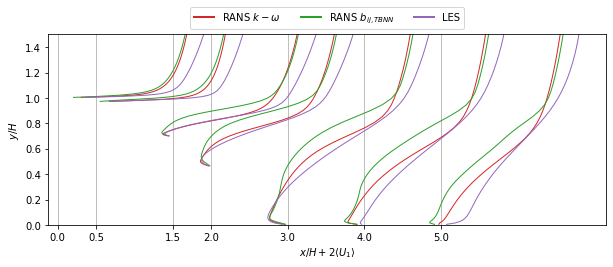

In [78]:
# set path to save figures
# fig_path = '/home/leonriccius/Desktop'

# select x locations to plot
x_data = [0.0, 0.5, 1.5, 2.0, 3.0, 4.0, 5.0]
tol = 4e-2
scale_x = 2.0
scale_fig = 1.2

# reshape arrays
nx, ny = 300, 150
grid_reshaped = grid_rans.reshape(ny, nx, 3)
u_levm_reshaped = u_levm.reshape(ny, nx, 3)
u_rans_reshaped = u_rans.reshape(ny, nx, 3)
u_dns_reshaped = u_dns.reshape(ny, nx, 3)

# # # seaborn colors scheme 1
colors = [sns.color_palette()[3],
         sns.color_palette()[2],
         sns.color_palette()[4],
         sns.color_palette()[0]]
# # seaborn colors scheme 2
# colors = ['b', 'g', 'r', 'c']
nx, ny = 300, 150
grid_reshaped = grid_rans.reshape(ny, nx, 3)

# custom color scheme
# colors = ['#F57680', '#5AABA3', '#565876', '#850C3E']
# colors = ['#FEC804', '#F26332', '#7A2D59', '#5995B7']

# linewidth
linewidth = 1.0

# select components
components = [0]

# set number of columns to plot
ncols = 1
nrows = len(components)

# create figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(scale_fig*7*ncols, scale_fig*3.0*nrows),
                        sharex=True, sharey=True, constrained_layout=True)

plt.xticks(x_data)

for i, cmp in enumerate(components):
    for j, val in enumerate(x_data):
        # find x location in grid
        x_loc = np.argmin(np.absolute(grid_reshaped[0,:,0] - val))
        x_val = grid_reshaped[0, x_loc, 0]

        # create mask and select points in the slice
        grid_slice = grid_reshaped[0:50, x_loc, 1]
        u_dns_slice = u_dns_reshaped[0:50, x_loc, cmp]
        u_levm_slice = u_levm_reshaped[0:50, x_loc, cmp]
        u_rans_slice = u_rans_reshaped[0:50, x_loc, cmp]
#         grid_slice = np.insert(grid_reshaped[:, x_loc, 1], 0, grid_y[0,x_loc])
#         u_dns_slice = np.insert(grid_u_dns[:, x_loc, cmp], 0, 0.0)
#         u_levm_slice = np.insert(grid_u_levm[:, x_loc, cmp], 0, 0.0)
#         u_rans_slice = np.insert(grid_u_rans[:, x_loc, cmp], 0, 0.0)

        # plot all bs for current slice
        axs.plot(scale_x*u_levm_slice + val, grid_slice, color=colors[0], linewidth=linewidth)
        axs.plot(scale_x*u_rans_slice + val, grid_slice, color=colors[1], linewidth=linewidth)
        axs.plot(scale_x*u_dns_slice + val, grid_slice, color=colors[2], linewidth=linewidth)
        axs.set_ylabel(r'$y/H$')
    
    # plot lower and upper wall of hill and grid
#     barymap.plot_periodic_hills_boundaries(axs)
    axs.grid(axis='x')

# plot legend    
leg = axs.legend([r'RANS $k-\omega$', r'RANS $b_{ij,TBNN}$', r'LES'], bbox_to_anchor=(0.5, 1.00),
                 loc='lower center', ncol=4)

axs.set_ylim([0.0, 1.5])

for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

# plot xlabel
axs.set_xlabel(r'$x/H + 2\langle U_1 \rangle$')

# save fig
fig_path = '/home/leonriccius/Documents/Leon_MastersThesis/figures_thesis/numerical_results/propagation/periodic_hills'
fig_name =  'Ux_section.pdf'
# plt.savefig(os.sep.join([fig_path, fig_name]), format='pdf')

In [41]:
np.vstack((np.expand_dims(np.array(0.0), axis=0), grid_y[:, x_loc]), dim=0)

TypeError: _vhstack_dispatcher() got an unexpected keyword argument 'dim'

In [66]:
nx, ny = 300, 150
grid_reshaped = grid_rans.reshape(ny, nx, 3)
u_rans_reshaped = u_rans.reshape(ny, nx, 3)
u_dns_reshaped = u_dns.reshape(ny, nx, 3)

In [69]:
grid_reshaped[0,:,0]

tensor([-7.3017, -7.2252, -7.1487, -7.0722, -6.9957, -6.9192, -6.8427, -6.7662,
        -6.6897, -6.6132, -6.5367, -6.4601, -6.3836, -6.3071, -6.2306, -6.1541,
        -6.0776, -6.0011, -5.9246, -5.8481, -5.7716, -5.6951, -5.6185, -5.5420,
        -5.4655, -5.3890, -5.3125, -5.2360, -5.1595, -5.0830, -5.0065, -4.9300,
        -4.8535, -4.7769, -4.7004, -4.6239, -4.5474, -4.4709, -4.3944, -4.3179,
        -4.2414, -4.1649, -4.0884, -4.0119, -3.9353, -3.8588, -3.7823, -3.7058,
        -3.6293, -3.5528, -3.4763, -3.3998, -3.3233, -3.2468, -3.1703, -3.0937,
        -3.0172, -2.9407, -2.8642, -2.7877, -2.7112, -2.6347, -2.5582, -2.4817,
        -2.4052, -2.3287, -2.2521, -2.1756, -2.0991, -2.0226, -1.9461, -1.8696,
        -1.7931, -1.7166, -1.6401, -1.5636, -1.4871, -1.4105, -1.3340, -1.2575,
        -1.1810, -1.1045, -1.0280, -0.9515, -0.8750, -0.7985, -0.7220, -0.6455,
        -0.5689, -0.4924, -0.4159, -0.3394, -0.2629, -0.1864, -0.1099, -0.0334,
         0.0431,  0.1196,  0.1961,  0.27